In [ ]:
# Basic imports
import os
import sys
import io 
import time
import pickle
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualization 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# Captum for model interpretability
from captum.attr import (
    FeatureAblation,
    FeaturePermutation,
    Occlusion,
    ShapleyValueSampling,
    Lime,
    KernelShap
)
from captum.metrics import infidelity, sensitivity_max

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

import captum

True
1


In [21]:
np.random.seed(1234)
torch.manual_seed(5678)

# Feature Attribution and Explainer Evaluation with Captum 

This notebook investigates feature attribution methods for TabNet models trained on multimodal Alzheimer’s disease biomarkers. It leverages the Captum library to compute perturbation-based explanations and quantitatively assess their reliability.

We focus on evaluating several attribution techniques—including Feature Ablation, Feature Permutation, Occlusion, Shapley Value Sampling, LIME, and Kernel SHAP—to understand feature contributions to predicted cognitive outcomes. To benchmark these explainers, we compute Infidelity and Sensitivity Max metrics, providing insights into their robustness and fidelity to the underlying model.

Visualizations include sorted bar plots of feature importance across methods and comparison plots to highlight agreement/disagreement between attribution approaches. Finally, results are saved for downstream visualization as brain region maps.

--- 

### Notebook structure

1. Load TabNet and Attention-Based Feature Importance
2. Captum Attribution Analysis
    1. Visualize and Compare Average Feature Attributions Across Methods
    2. Generate and Save Per-Method Feature Importance Barplots
    3. Export Feature Importances for Brain Mapping
3. Explainer Evaluation Metrics
    1. Compute Infidelity
    2. Compute Sensitivity Max
    3. Summarize and Save Evaluation Metrics

#  Load TabNet and Attention-Based Feature Importance

In [22]:
retrain = False

data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]
df_select_features.columns = ["RNA", "CSF", "DNA", "MRIth"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [23]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [24]:
results_file = '../pickle/training_2_dict_results.pickle'

if torch.cuda.is_available():
    print("Load GPU TabNet")
    if os.path.exists(results_file):
        with open(results_file, "rb") as f:
            all_dict_results = pickle.load(f)
    tabnet_model = all_dict_results[9]["model"] # Corresponds to TabNet trained in notebook #3  

else : 
    print("Load CPU TabNet")
    if retrain : 
        all_dict_results = []
        tabnet_model =  TabNetModelWrapper(n_a=8, n_d=8)
    else :  
        class CPU_Unpickler(pickle.Unpickler):
            def find_class(self, module, name):
                if module == 'torch.storage' and name == '_load_from_bytes':
                    return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
                else:
                    return super().find_class(module, name)
            
        if os.path.exists(results_file): 
            with open(results_file, "rb") as f:
                all_dict_results = CPU_Unpickler(f).load()
            
        tabnet_model = all_dict_results[9]["model"] # Corresponds to TabNet trained in notebook #3  

        model_instance = tabnet_model.model
        model_instance.device_name = "cpu"
        model_instance.network.to(torch.device("cpu"))

        tabnet_model.model = model_instance.network.to("cpu")

        print(type(tabnet_model))           # Should be your wrapper class
        print(type(tabnet_model.model))     # Should be <class 'pytorch_tabnet.tab_model.TabNetRegressor'>
        print(hasattr(tabnet_model.model, 'device_name'))  # Should be T
        tabnet_model.model.device_name = "cpu"

        model_cpu = TabNetRegressor()
        model_cpu.network = tabnet_model.model  # Assign your TabNet object
        model_cpu.device_name = "cpu"
        model_cpu.device = torch.device("cpu")

continuous_model  = imputer = KNNImputer(n_neighbors=5)
name_continuous_imputer  = "KNNImputer_5"
ordinal_model =  KNNImputer(n_neighbors=1)
name_ordinal_imputer = "KNNImputer"
name_model = "TabNetRegressor" # "XGBoostRegressor"#  "TabNetRegressor"

Load GPU TabNet


In [25]:
ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

# Separate imputers for ordinal and continuous data
print("Using separate imputers for ordinal and continuous data.")

df_X_train = df_X_train.copy()
df_X_test = df_X_test.copy()

for col in ordinal_features:
    df_X_train[col] = df_X_train[col].astype("category")
    df_X_test[col] = df_X_test[col].astype("category")

# Continuous Imputation Transformer (Example: SimpleImputer)
continuous_imputer = Pipeline([
    (name_continuous_imputer, continuous_model),
])

# Ordinal Imputation Transformer (Example: KNN Imputer)
ordinal_imputer = Pipeline([
    (name_ordinal_imputer, ordinal_model)
])

# Create a ColumnTransformer to apply the appropriate imputer to each type of variable
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_imputer, ordinal_features),
        ('continuous', continuous_imputer, continuous_features)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

    # Separate imputers for ordinal and continuous data

# Fit and transform, then convert back to DataFrame with original column names
start = time.time()
pipeline.fit(df_X_train)
end = time.time()

impute_model_time = end - start

X_train_imputed = pipeline.transform(df_X_train)
df_X_train_imputed = df_X_train.copy()
df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

# Transform the test set
if df_X_test.isna().any().any(): 
    X_test_imputed = pipeline.transform(df_X_test)
    df_X_test_imputed = df_X_test.copy()
    df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
else : 
    print("No NaN in test data -> Keep as it is. ")
    df_X_test_imputed = df_X_test

df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category", errors='ignore')
df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category", errors='ignore')

# Demographics adjustment for y
demographic_adjustment_y = DemographicAdjustmentTransformer()

y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

# Demographics adjustment for X
demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

# Standardize only continuous features
scaler = StandardScaler()

X_train_adjusted[continuous_features] = scaler.fit_transform(X_train_adjusted[continuous_features])
X_test_adjusted[continuous_features] = scaler.transform(X_test_adjusted[continuous_features])

if retrain: 
    # Perform prediction and save variables
    start = time.time()
    tabnet_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start
    print("Training time: ", end - start)
else : 
    predict_model_time = None

y_pred_adjusted = tabnet_model.predict(X_test_adjusted.values)

y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

params = {
    "ordinal_imputer": name_ordinal_imputer, 
    "continuous_imputer": name_continuous_imputer, 
    "model": name_model, "train_shape" : X_train_adjusted.shape, 
    "test_shape": X_test_adjusted.shape
}

def compute_all_metrics(y_test, y_pred): 
    # Metrics computed in adjusted space
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test,y_pred, multioutput="raw_values")
    explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

    try: 
        corr_p = correlation(y_pred, y_test)
    except: 
        print("Problem when computing correlation!")
        if type(y_test) != type(y_pred): 
            print("Type of inputs is different.")
            corr_p = None
        else : 
            corr_p = pearsonr(y_test, y_pred)

    return mse_score, mae_score, r2, explained_variance, corr_p

if df_X_test.shape[0] != 1: 

    # Metrics computed in adjusted space
    mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

    results_adj = {
        "mse_score": mse_score_adj, 
        "mae_score":mae_score_ajd, 
        "r2":r2_adj, 
        "explained_variance":explained_variance_adj, 
        "corr":corr_adj, 
    }

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

    results_org = {
        "mse_score": mse_score, 
        "mae_score": mae_score, 
        "r2": r2, 
        "explained_variance": explained_variance, 
        "corr": corr, 
    }
    
    print("Saving predictions in dict!")
    results_adj = {
        "y_pred": y_pred_adjusted.values, 
        "y_test": y_test_adjusted.values,
    }

    results_org = {
        "y_pred": y_pred.values, 
        "y_test": df_y_test.values,
    }


dict_results = {
    "params": params, 
    "imputation_time": impute_model_time,
    "fitting_time": predict_model_time, 
    "results_adj": results_adj, 
    "results_org": results_org
    }

Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
Saving predictions in dict!


In [26]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

In [27]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

min_x = merged_df['y_pred'].min()
max_x = merged_df['y_pred'].max()
x_grid = np.linspace(min_x, max_x, 100)

line_dfs = []

for domain in merged_df['cognitive_domain'].unique():
    subdf = merged_df[merged_df['cognitive_domain'] == domain]

    # Metrics
    correlation = subdf["y_pred"].corr(subdf["y_test"])
    mae = mean_absolute_error(subdf["y_test"], subdf["y_pred"])

    print(f"Domain: {domain}, Pearson correlation: {pearsonr(subdf['y_pred'], subdf['y_test'])[0]:.3f}, Pearson p-value: {pearsonr(subdf['y_pred'], subdf['y_test'])[1]:.3f}, MAE: {mae:.3f}")
    
    
    # Prepare X with intercept
    X = sm.add_constant(subdf['y_pred'])
    y = subdf['y_test']
    
    model = sm.OLS(y, X).fit()
    
    # Create design matrix for prediction (constant + x_grid)
    X_pred = sm.add_constant(x_grid)
    
    # Get predictions and standard errors
    preds = model.get_prediction(X_pred)
    pred_summary = preds.summary_frame(alpha=0.05)
    
    # Use standard error of the mean prediction
    df_line = pd.DataFrame({
        'y_pred': x_grid,
        'y_test_pred': pred_summary['mean'],
        'se_lower': pred_summary['mean'] - pred_summary['mean_se'],
        'se_upper': pred_summary['mean'] + pred_summary['mean_se'],
        'cognitive_domain': domain
    })
    
    line_dfs.append(df_line)

line_df = pd.concat(line_dfs, axis=0)

Domain: ADNI_MEM, Pearson correlation: 0.678, Pearson p-value: 0.011, MAE: 0.677
Domain: ADNI_EF, Pearson correlation: 0.722, Pearson p-value: 0.005, MAE: 0.633
Domain: ADNI_VS, Pearson correlation: 0.553, Pearson p-value: 0.050, MAE: 0.473
Domain: ADNI_LAN, Pearson correlation: 0.556, Pearson p-value: 0.049, MAE: 0.749


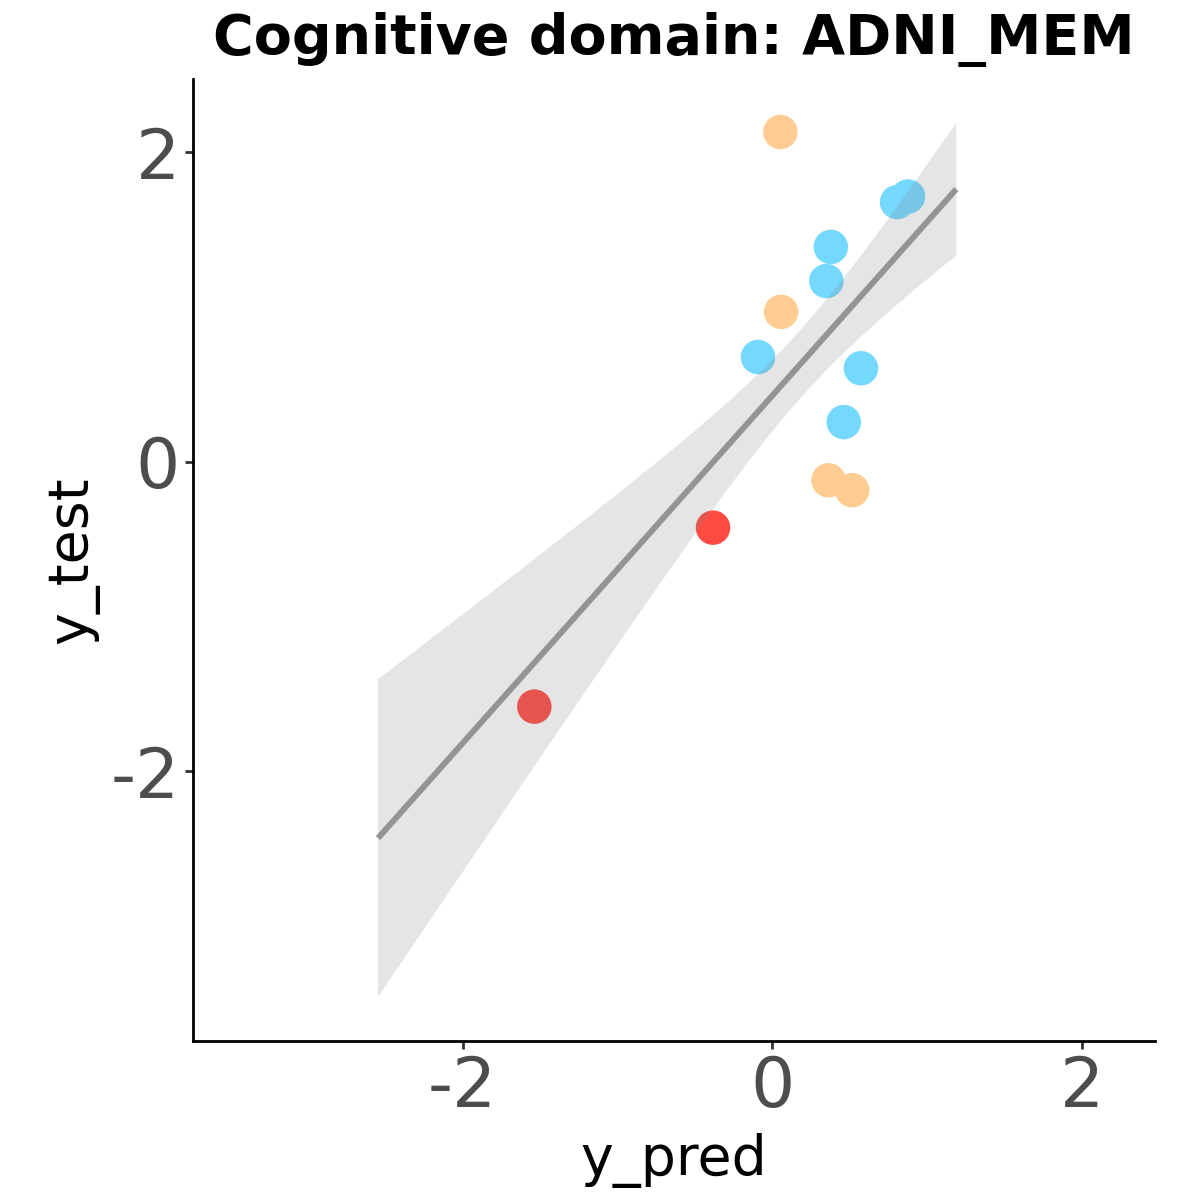

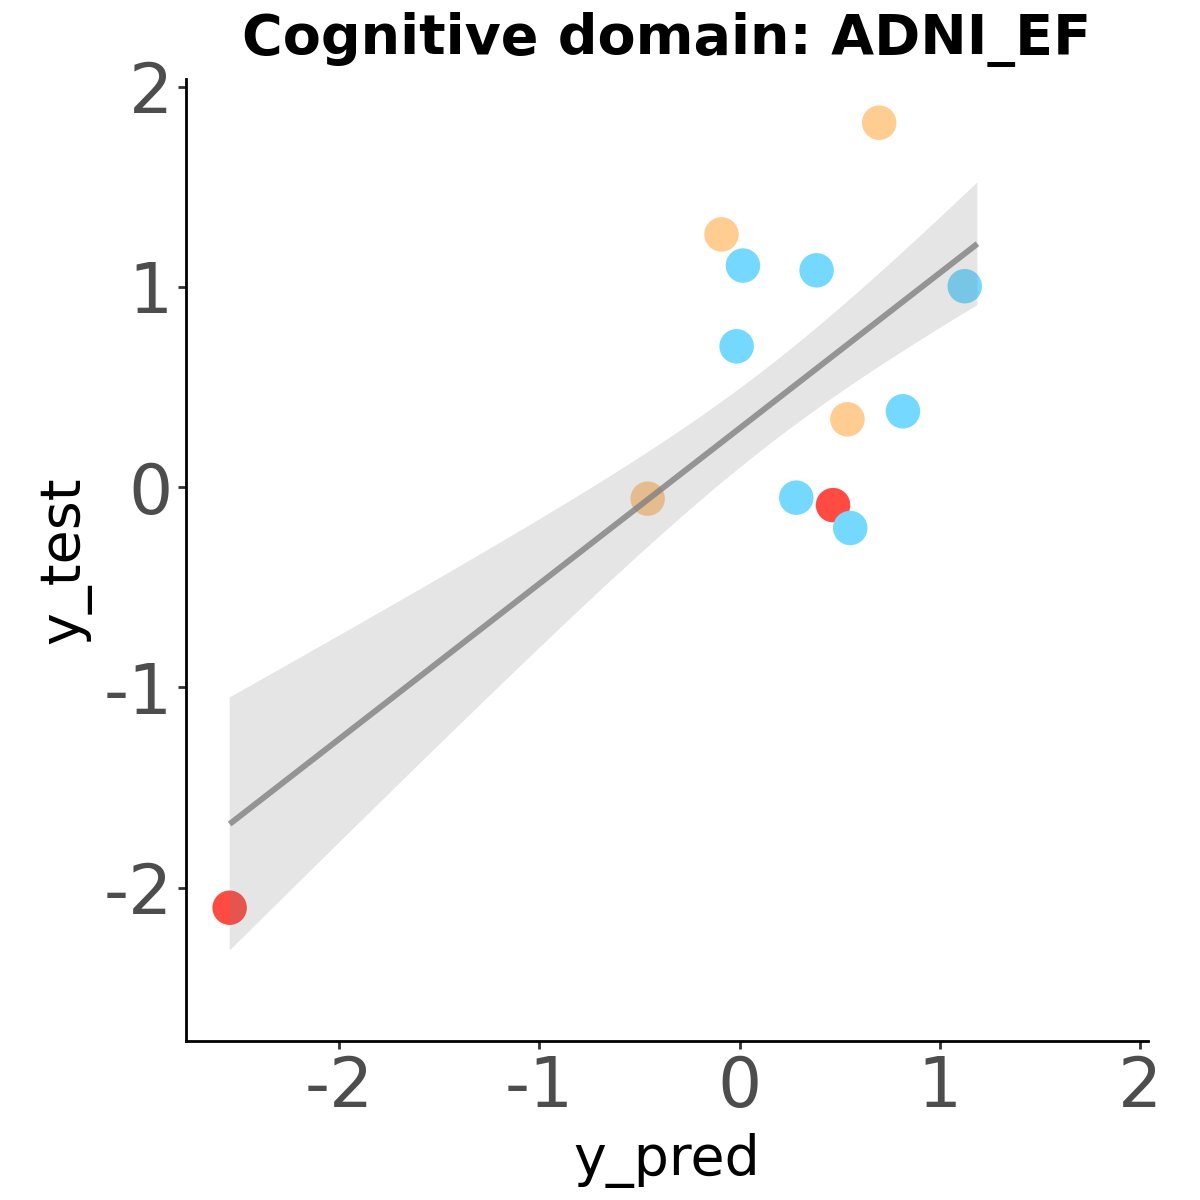

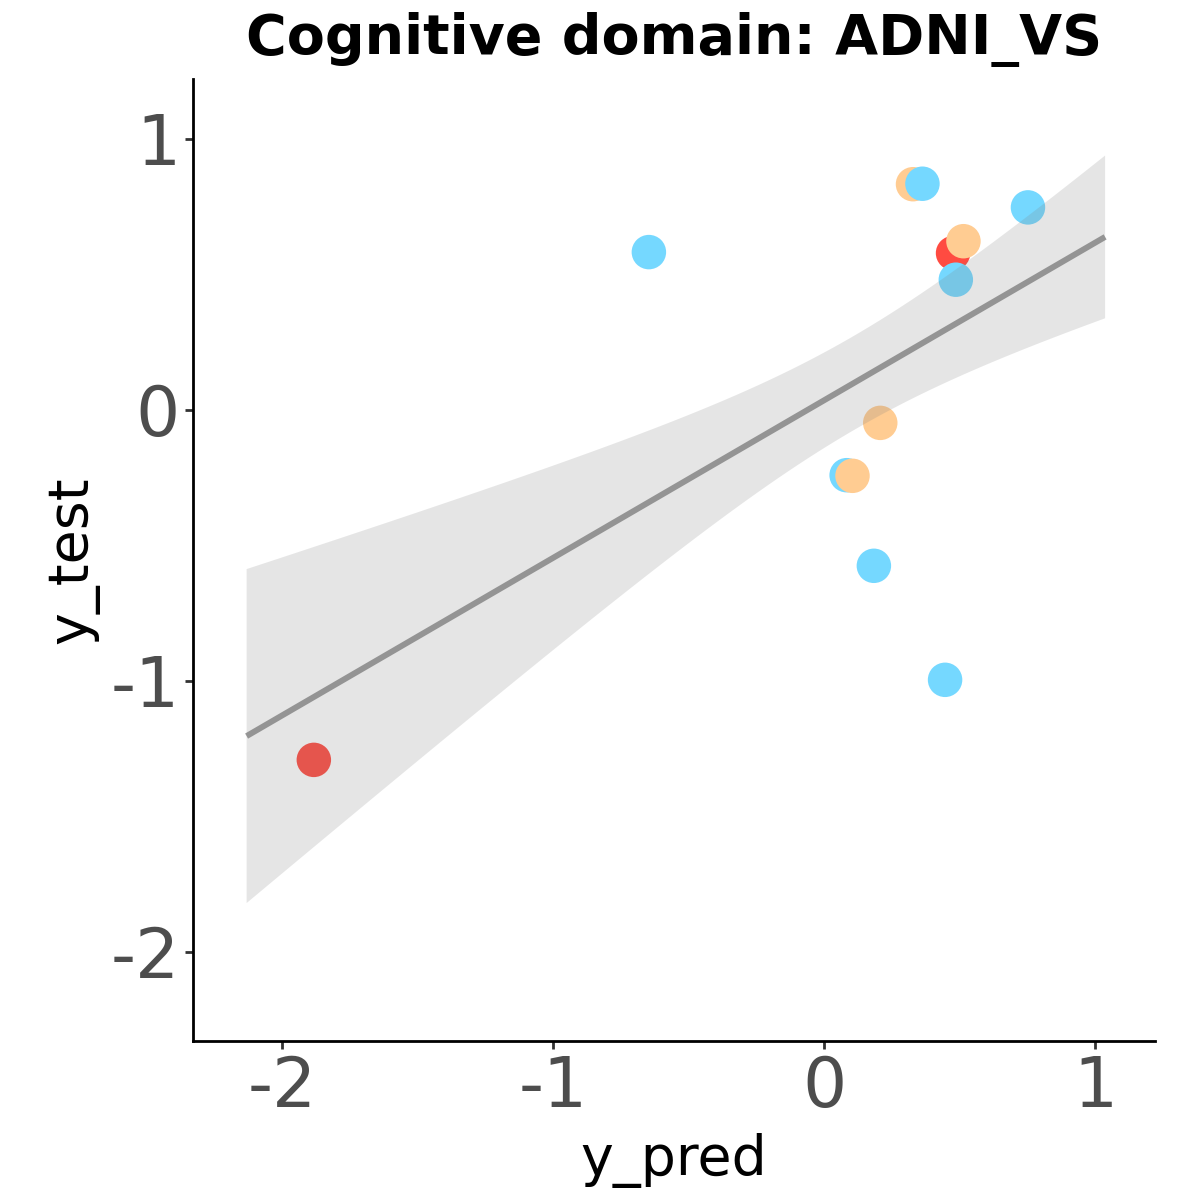

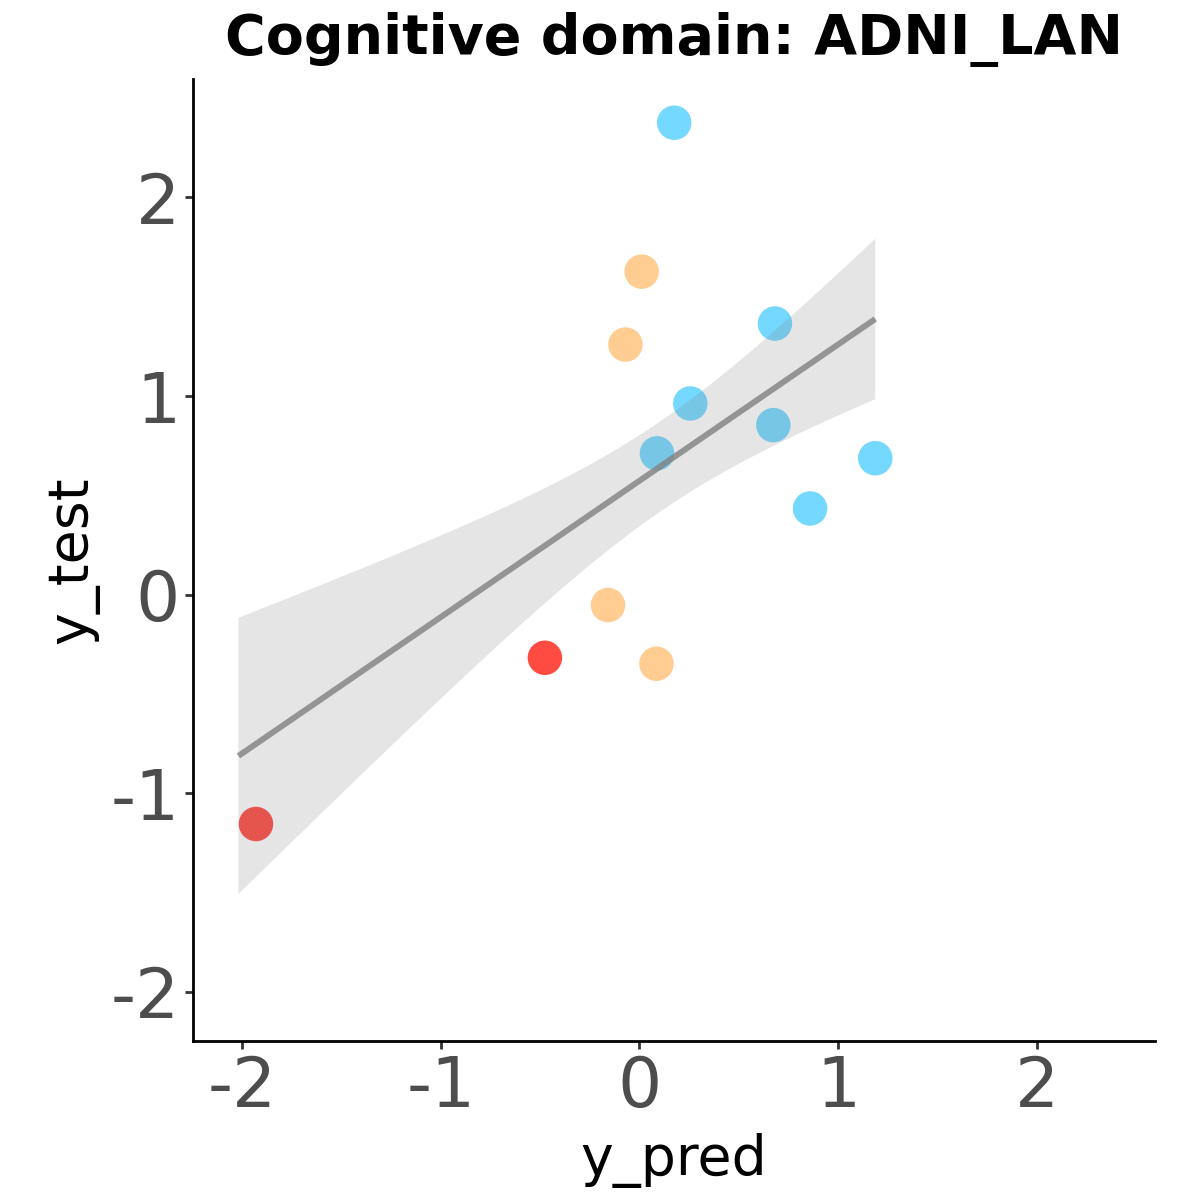

In [10]:
from plotnine import (
    ggplot, aes, geom_point, geom_ribbon, geom_line, scale_color_manual, 
    theme_bw, theme, element_text, element_line, labs, coord_fixed, 
    scale_x_continuous, scale_y_continuous, element_blank
)

plots = {}

for domain in merged_df['cognitive_domain'].unique():
    subdf = merged_df[merged_df['cognitive_domain'] == domain]
    subline_df = line_df[line_df['cognitive_domain'] == domain]

    # Use SE bounds instead of CI
    min_limit = min(subline_df['se_lower'].min(), subdf['y_pred'].min(), subdf['y_test'].min())
    max_limit = max(subline_df['se_upper'].max(), subdf['y_pred'].max(), subdf['y_test'].max())

    p = (
        ggplot(subdf, aes(x="y_pred", y="y_test", color="DX")) +
        geom_point(size=6, alpha=1.) +
        geom_ribbon(subline_df, aes(x='y_pred', ymin='se_lower', ymax='se_upper', group='cognitive_domain'),
                    fill='gray', alpha=0.2, inherit_aes=False) +
        geom_line(subline_df, aes(x='y_pred', y='y_test_pred', group='cognitive_domain'),
                  color='gray', size=1.2, alpha=0.8, inherit_aes=False) +
        scale_color_manual(values=dx_palette) +
        coord_fixed(ratio=1) +
        scale_x_continuous(limits=(min_limit, max_limit)) +
        scale_y_continuous(limits=(min_limit, max_limit)) +
        theme_bw() +
        theme(
            figure_size=(6, 6),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line_x=element_line(color="black"),
            axis_line_y=element_line(color="black"),
            strip_text=element_text(size=20, weight="bold"),
            axis_title=element_text(size=20),
            axis_text=element_text(size=25),
            legend_position="none",
            plot_title=element_text(size=20, weight="bold", ha="center")
        ) +
        labs(title=f"Cognitive domain: {domain}")
    )
    
    plots[domain] = p
    display(p)


In [10]:
category_palette = {'RNA': full_palette["yellow"],
 'MRIth': full_palette["cyan"],
 'CSF': full_palette["blue"],
 'DNA': full_palette["orange"],
 'ADNI_cog': full_palette["green"]
 }
sns.color_palette(category_palette.values())

[(1.0, 0.6666666666666666, 0.2549019607843137),
 (0.8431372549019608, 0.8274509803921568, 0.2549019607843137),
 (0.4588235294117647, 0.8470588235294118, 1.0),
 (1.0, 0.29411764705882354, 0.2549019607843137),
 (0.4392156862745098, 0.8509803921568627, 0.2549019607843137)]

In [11]:
# Function to clean up y-tick labels
def clean_ytick_label(label):
    label = label.replace("_epsilon", "").replace("_Cortical", "")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("_", " ")  # Remove remaining underscores
    if len(label.split(" || ")) > 1: 
        label = label.split(" || ")[1]
    
    return label

In [12]:
n_features = 20

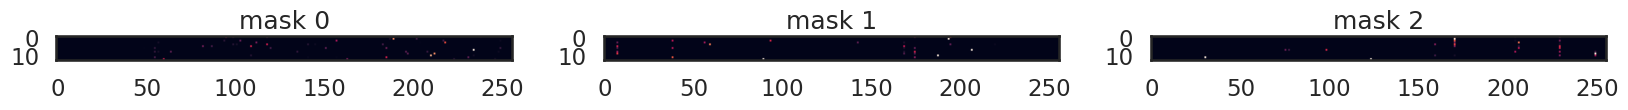

In [13]:
explain_matrix, masks = tabnet_model.model.explain(X_test_adjusted.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

<Figure size 640x480 with 0 Axes>

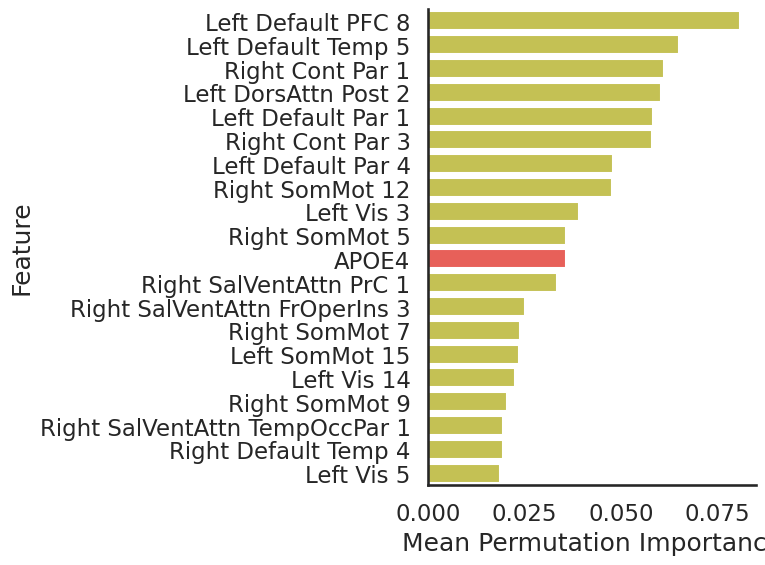

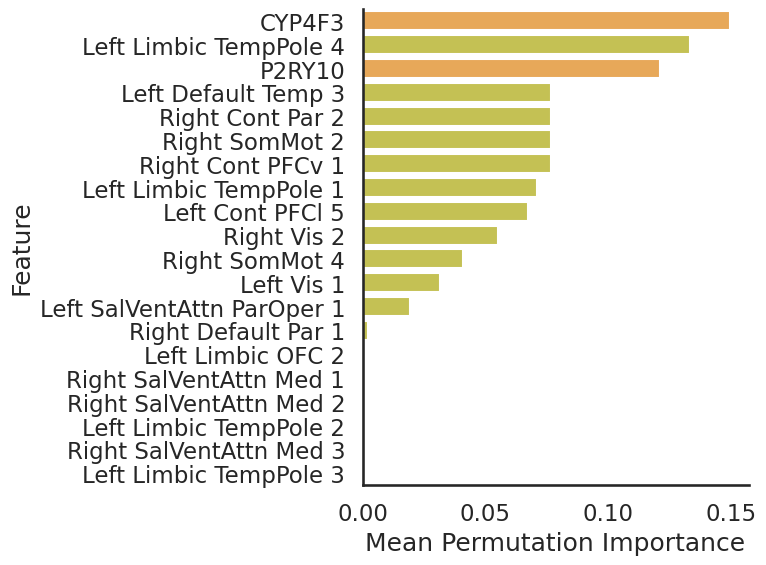

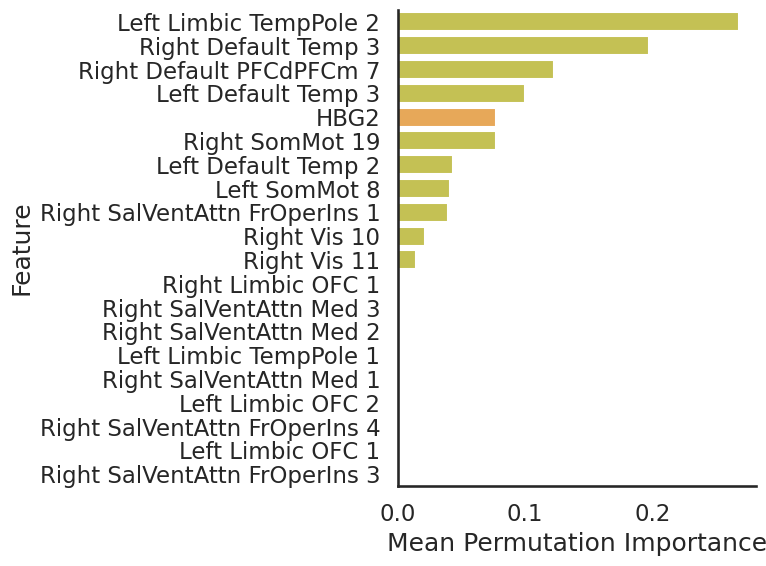

In [14]:
for item in masks.values(): 

    sns.despine()
    plt.tight_layout()
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    
    # Select the top n features for the current target
    importances = pd.DataFrame({"Feature": df_X.columns.tolist(), "Importance": item.mean(0)})
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
    )

    importances.sort_values("Importance", ascending=False)
    
    # Create the barplot
    ax = sns.barplot(
        x="Importance", y="Feature", data=importances.sort_values("Importance", ascending=False).head(20),
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)

    ax.set_xlabel("Mean Permutation Importance", fontsize=18)
    ax.set_ylabel("Feature", fontsize=18)
    
    # Remove legend from each individual plot
    ax.legend().set_visible(False)
    
    sns.despine()
    plt.tight_layout()


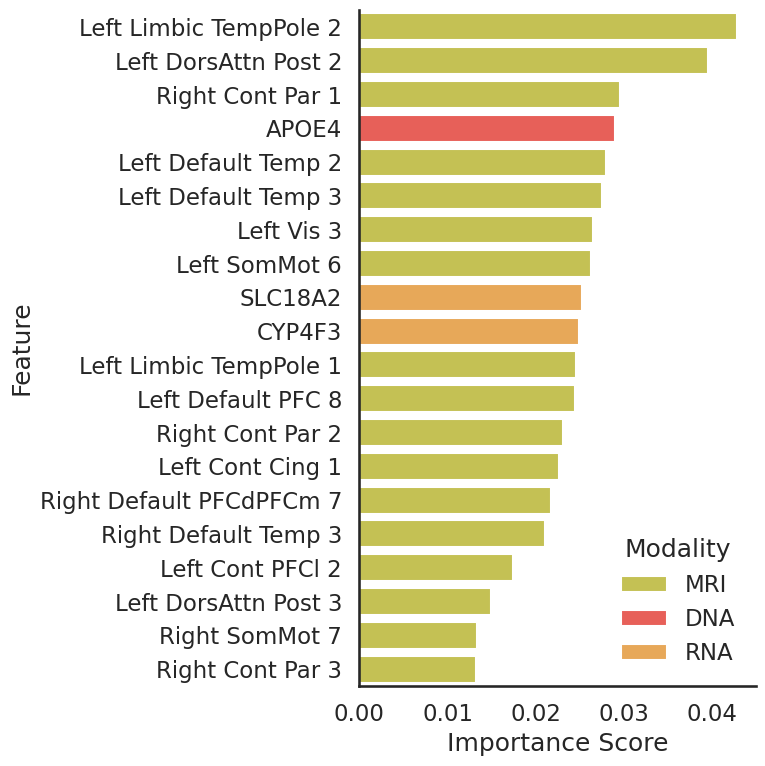

In [15]:
# Extract feature importances
feature_importances = tabnet_model.model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top N features
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Add a 'Category' column based on the 'select' dictionary
top_features_df['Modality'] = top_features_df['Feature'].map(
    lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
)

sns.set_style("white")
sns.set_context("talk")
#sns.set(font="Helvetica")

# Plot the barplot with category-based coloring
plt.figure(figsize=(8, 8))

ax = sns.barplot(
    data=top_features_df,
    x="Importance",
    y="Feature",
    hue="Modality", 
    palette=category_palette
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")

# Apply changes to y-tick labels for each subplot
#for ax in g.axes.flat:
# Get current y-tick labels
ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]

# Update y-tick labels
new_labels = [clean_ytick_label(label) for label in ytick_labels]
ax.set_yticklabels(new_labels)

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Replace "MRIth" with "MRI" in the labels
updated_labels = [label.replace("MRIth", "MRI") for label in labels]

# Set the updated legend
ax.legend(handles, updated_labels, title="Modality", loc="best", frameon=False)

sns.despine()

plt.tight_layout()
plt.show()


In [16]:
local_importance = tabnet_model.model.feature_importances_
local_importance = local_importance[df_X.columns.isin(select_MRIthickness)]

In [17]:
pd.DataFrame(local_importance).to_csv('../pickle/TabNet_local_MRI.csv', index=False, header=False)

# Captum Attribution Analysis

In [19]:
X_tensor = torch.tensor(X_train_adjusted.values, dtype=torch.float32)
y_tensor = torch.tensor(df_y_train.values, dtype=torch.float32)

In [ ]:
def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
) -> dict:
    """
    Compute perturbation-based attributions for a selected output in a multi-output model.

    Args:
        model_predict: callable numpy-output predictor, shape (N, D)
        X: torch.Tensor of shape (N, F)
        output_idx: which output dimension to explain
        shapley_samples: number of samples for ShapleyValueSampling

    Returns:
        dict of attribution tensors, e.g., {'ablation': Tensor(N,F), ...}
    """
    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    attrs = {}
    attrs['ablation'] = FeatureAblation(forward_i).attribute(X, baselines=0)
    attrs['permutation'] = FeaturePermutation(forward_i).attribute(X)
    attrs['occlusion'] = Occlusion(forward_i).attribute(X, baselines=0, sliding_window_shapes=(1,))
    attrs['shapley'] = ShapleyValueSampling(forward_i).attribute(X, baselines=0, n_samples=shapley_samples)

    return attrs


In [ ]:
def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
):
    """
    Computes attribution maps (as torch.Tensors) for a selected output
    using Captum explainers: Ablation, Permutation, Occlusion, ShapleySampling,
    plus Captum's Lime and KernelShap.
    """
    def forward_predict(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    explainers = {}

    # Existing Captum explainers
    explainers['ablation'] = FeatureAblation(forward_predict).attribute(X, baselines=0)
    explainers['permutation'] = FeaturePermutation(forward_predict).attribute(X)
    explainers['occlusion'] = Occlusion(
        forward_predict
    ).attribute(X, baselines=0, sliding_window_shapes=(1,))
    explainers['shapley'] = ShapleyValueSampling(
        forward_predict
    ).attribute(X, baselines=0, n_samples=shapley_samples)
    explainers['lime'] = Lime(forward_predict).attribute(
        X, baselines=0, n_samples=shapley_samples
    )
    explainers['kernelshap'] = KernelShap(forward_predict).attribute(
        X, baselines=0, n_samples=shapley_samples
    )

    return explainers,  forward_predict


In [ ]:
def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
):
    """
    Returns:
    - `attr_tensors`: precomputed attributions for each explainer
    - `explanation_functions`: callables that return attributions given new X
    - `forward_predict`: callable model forward function
    """
    def forward_predict(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    attr_tensors = {}
    explanation_functions = {}

    # --- Ablation ---
    ablator = FeatureAblation(forward_predict)
    attr_tensors["ablation"] = ablator.attribute(X, baselines=0)
    explanation_functions["ablation"] = lambda x: ablator.attribute(x, baselines=0)

    # --- Permutation ---
    permutor = FeaturePermutation(forward_predict)
    attr_tensors["permutation"] = permutor.attribute(X)
    explanation_functions["permutation"] = lambda x: permutor.attribute(x)

    # --- Occlusion ---
    occluder = Occlusion(forward_predict)
    attr_tensors["occlusion"] = occluder.attribute(X, baselines=0, sliding_window_shapes=(1,))
    explanation_functions["occlusion"] = lambda x: occluder.attribute(
        x, baselines=0, sliding_window_shapes=(1,)
    )

    # --- Shapley Sampling ---
    shapley = ShapleyValueSampling(forward_predict)
    attr_tensors["shapley"] = shapley.attribute(X, baselines=0, n_samples=shapley_samples)
    explanation_functions["shapley"] = lambda x: shapley.attribute(
        x, baselines=0, n_samples=shapley_samples
    )

    # --- LIME ---
    lime = Lime(forward_predict)
    attr_tensors["lime"] = lime.attribute(X, baselines=0, n_samples=shapley_samples)
    explanation_functions["lime"] = lambda x: lime.attribute(
        x, baselines=0, n_samples=shapley_samples
    )

    # --- KernelSHAP ---
    kshap = KernelShap(forward_predict)
    attr_tensors["kernelshap"] = kshap.attribute(X, baselines=0, n_samples=shapley_samples)
    explanation_functions["kernelshap"] = lambda x: kshap.attribute(
        x, baselines=0, n_samples=shapley_samples
    )

    return attr_tensors, explanation_functions, forward_predict


In [23]:
model_predict = tabnet_model.predict  # your numpy-based predictor

explainers_0, explainer_funct_0, forward_0 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=0, shapley_samples=50
)

In [24]:
explainers_1, explainer_funct_1,  forward_1 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=1, shapley_samples=50
)

In [25]:
explainers_2, explainer_funct_2,  forward_2 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=2, shapley_samples=50
)

In [26]:
explainers_3, explainer_funct_3,  forward_3 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=2, shapley_samples=50
)

## Visualize and Compare Average Feature Attributions Across Methods

In [ ]:
def format_attrs_for_plot(explainers: dict, feature_names: list) -> pd.DataFrame:
    """
    Convert explainers dict to a DataFrame with columns:
    'method', 'feature', 'avg_abs_attr', 'std_abs_attr'.
    
    explainers: dict e.g. {'ablation': Tensor(N,F), ...}
    feature_names: list of length F
    """
    rows = []
    for method, tensor in explainers.items():
        arr = tensor.detach().cpu().numpy()  # shape (N, F)
        avg_abs = np.mean(np.abs(arr), axis=0)  # vector length F
        std_abs = np.std(np.abs(arr), axis=0)  # vector length F
        for feat_name, avg, std in zip(feature_names, avg_abs, std_abs):
            rows.append({
                'method': method,
                'feature': feat_name,
                'avg_abs_attr': avg,
                'std_abs_attr': std
            })
    return pd.DataFrame(rows)

In [28]:
# Rename mappings
method_rename = {
    "ablation": "Ablation",
    "permutation": "Permutation",
    "occlusion": "Occlusion",
    "shapley": "Shapley",
    "lime": "LIME",
    "kernelshap": "KernelSHAP"
}

target_rename = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}

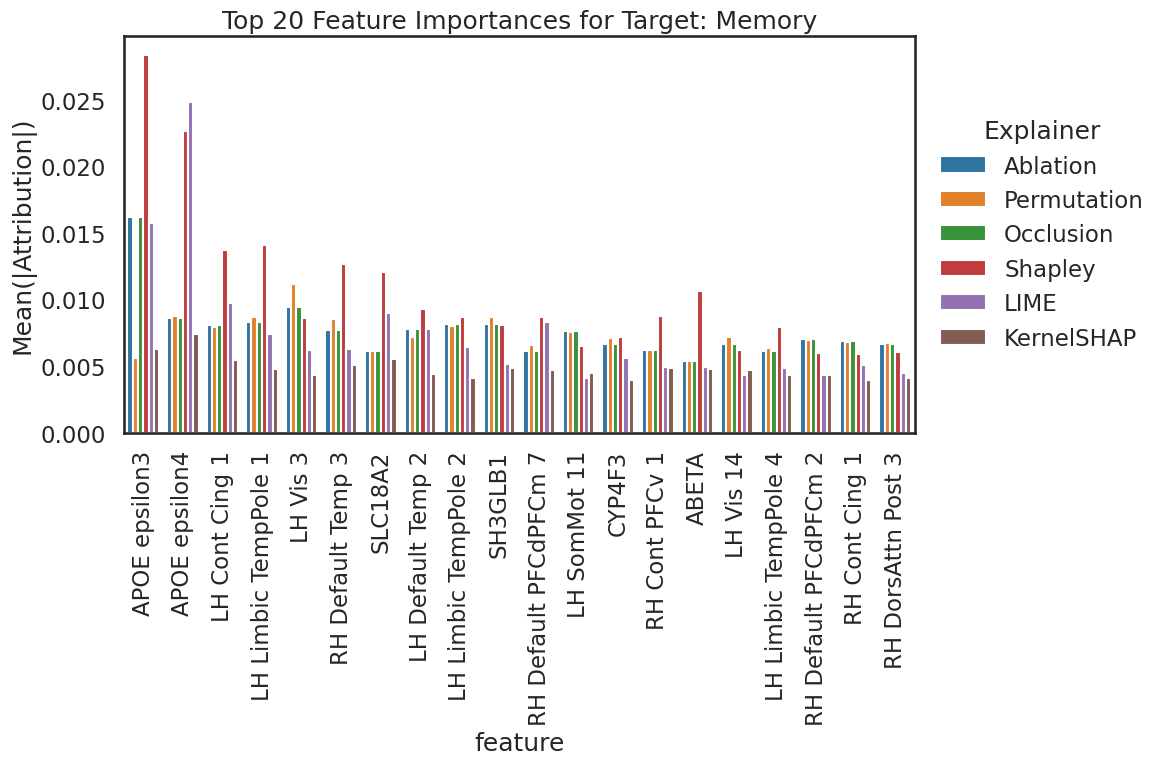

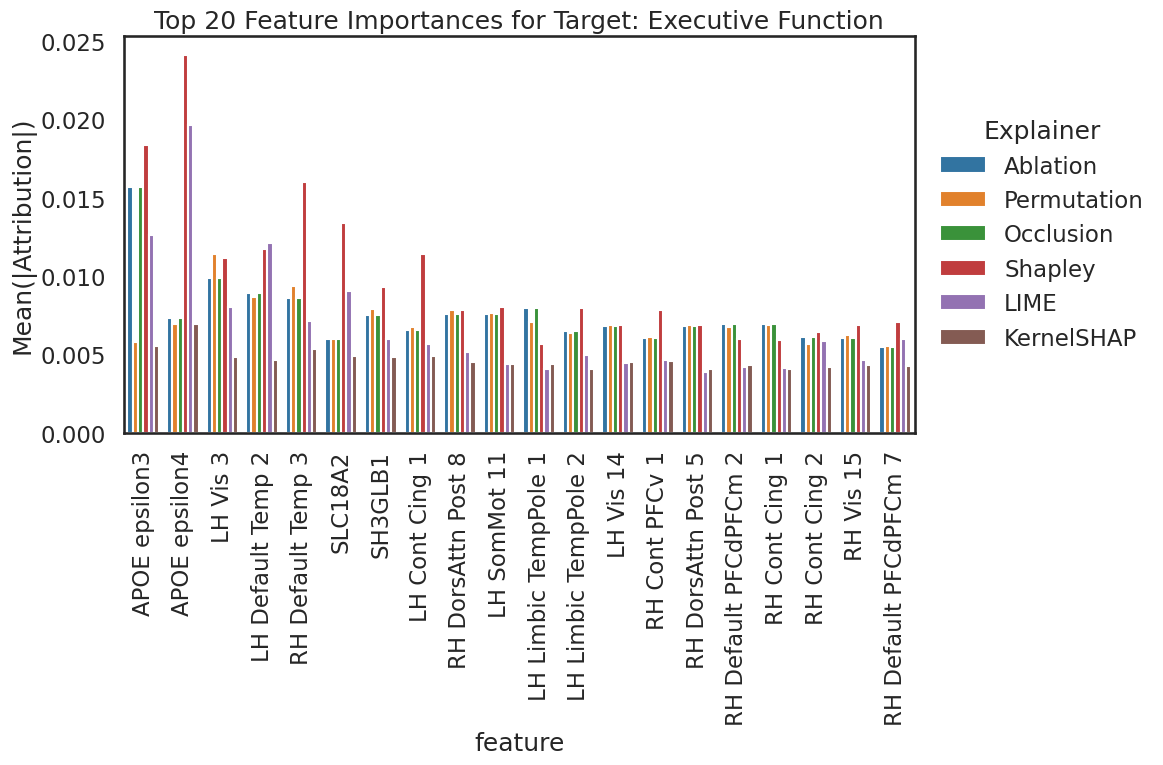

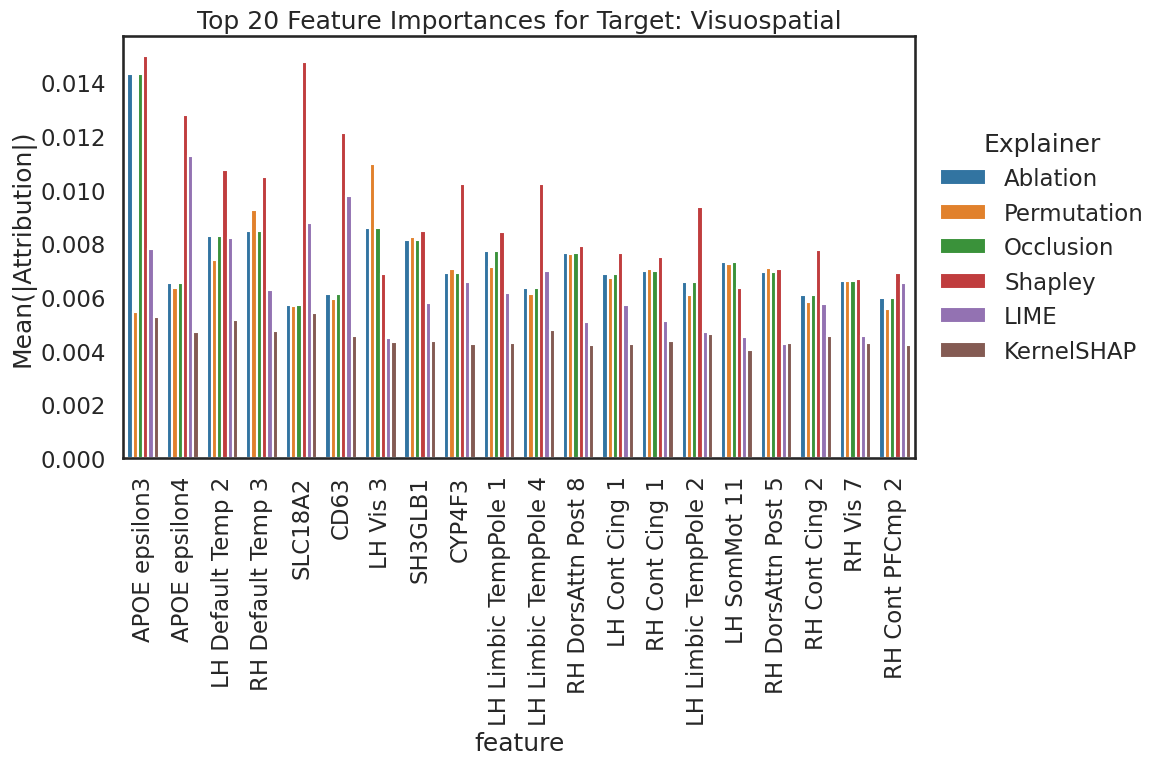

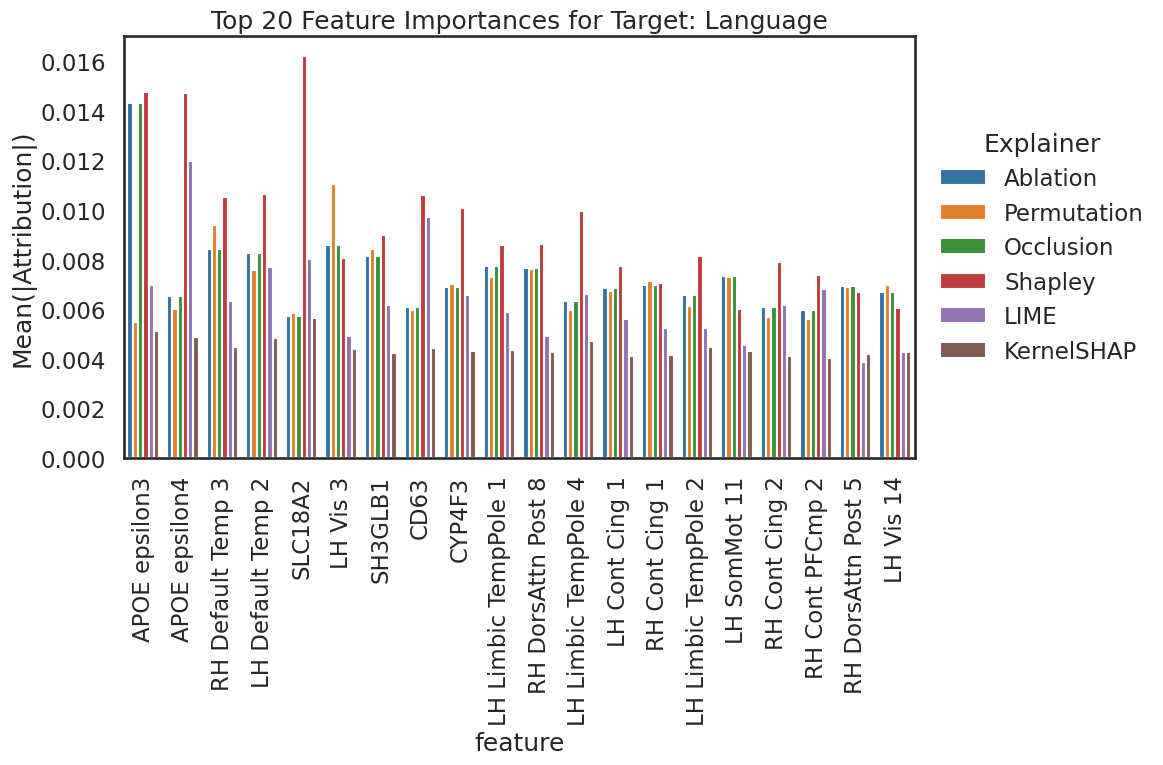

In [29]:
sns.set_context("talk")
sns.set_style("white")

n_features = 20
plt_std = False
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

for target, explainer in zip(df_y.columns, all_explainers): 
    
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    # After computing avg_abs_attr
    df_attr['avg_abs_attr_norm'] = df_attr.groupby('method')['avg_abs_attr'].transform(lambda x: x / x.sum())
    top_ft_to_plot = df_attr.groupby("feature")['avg_abs_attr_norm'].mean().sort_values(ascending=False).head(n_features).index.tolist()

    plt_df = df_attr[df_attr['feature'].isin(top_ft_to_plot)]

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=plt_df,
        x='feature',
        y='avg_abs_attr_norm',
        hue='method',
        # ci=None,  # Disable Seaborn's internal CI calculation
        dodge=True,
        capsize=0.1,
        order=top_ft_to_plot
    )
    
    # Add error bars manually
    features = plt_df['feature'].unique()
    methods = plt_df['method'].unique()
    n_methods = len(methods)
    total_width = 0.8  # seaborn default total width for group
    single_width = total_width / n_methods

    if plt_std == True: 

        for i, feature in enumerate(features):
            for j, method in enumerate(methods):
                x = i - total_width/2 + j * single_width + single_width/2
                row = plt_df[(plt_df['feature'] == feature) & (plt_df['method'] == method)]
                if row.empty:
                    continue
                y = row['avg_abs_attr'].values[0]
                yerr = row['std_abs_attr'].values[0]
                plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black', capsize=3, elinewidth=1)


    ax.set_ylabel("Mean(|Attribution|)")
        
    # Modify x-tick labels
    xtick_labels = [label.get_text().replace('_Cortical', '').replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xtick_labels, rotation=90)

    # Use renamed target title
    plt.title(f'Top {n_features} Feature Importances for Target: {target_rename.get(target, target)}')


    sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

    # Create custom legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [method_rename.get(label, label) for label in labels]
    ax.legend(handles, new_labels,
              bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0,
              title="Explainer", frameon=False)

    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"../figures/captum/tabnet_perturbation_attr_comparison_{target}.png", bbox_inches="tight")


## Generate and Save Per-Method Feature Importance Barplots

In [67]:
# Parameters
n_features = 20
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

# Mappings & style
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}
sns.set_style("white")
sns.set_context("talk")

# Convert df_select_features to dict of lists {category: [features]}
category_dict = df_select_features.to_dict(orient="list")

# Reverse mapping feature -> category for quick lookup
feature_to_category = {}

for cat, features in category_dict.items():
    for f in features:
        feature_to_category[f] = cat

# Define your palette (make sure it matches categories)
category_palette = {'RNA': full_palette["yellow"],
 'MRIth': full_palette["cyan"],
 'CSF': full_palette["blue"],
 'DNA': full_palette["orange"],
 'ADNI_cog': full_palette["green"]
 }
sns.color_palette(category_palette.values())

def clean_ytick_label(label):
    # Your cleaning logic here, e.g.:
    label = label.replace("_", " ")
    label = label.replace("LH", "Left ")
    label = label.replace("RH", "Right ")
    label = label.replace("Cortical", "")
    return label

n_features = 20
plt_std = False
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

all_n_features = {}   

for target, explainer in zip(df_y.columns, all_explainers): 
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    
    methods = df_attr['method'].unique()
    
    for method in methods:
        df_method = df_attr[df_attr['method'] == method]
        top_method_feats = df_method.sort_values('avg_abs_attr', ascending=False).head(n_features)
        
        # Map modality category for colors (assuming df_select_features is defined)
        top_method_feats['Category'] = top_method_feats['feature'].map(
            lambda feature: next(
                (key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 
                'Unknown')
        )
        
        plt.figure(figsize=(8, 6))
        sns.set_style("white")
        sns.set_context("talk")
        
        ax = sns.barplot(
            data=top_method_feats,
            y='feature',  # horizontal bars
            x='avg_abs_attr',
            hue='Category',
            palette=category_palette,
            orient='h'
        )
        
        # Clean y-tick labels if needed
        ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
        new_labels = [clean_ytick_label(label) for label in ytick_labels]
        ax.set_yticklabels(new_labels)
        ax.set_xlim((0, 0.11))
        ax.set_xticks([0, 0.05, 0.1])
        
        readable_title = readable_names.get(target, target)
        ax.set_title(f'{readable_title} - {method}', fontsize=18)
        ax.set_xlabel('Average Absolute Attribution', fontsize=16)
        ax.set_ylabel('Feature', fontsize=16)
        
        ax.legend(loc='best', fontsize=12)
        sns.despine()
        plt.tight_layout()
        
        plt.savefig(f"../figures/captum/{target}_{method}_top_features.png", bbox_inches='tight')
        plt.close()


In [ ]:
def plot_top_features_square_equal(
    all_explainers,
    df_y,
    df_select_features,
    X_test_adjusted,
    readable_names,
    category_palette,
    output_dir,
    n_features=20
):
    # Create output folder
    os.makedirs(output_dir, exist_ok=True)

    # Helper: Clean tick labels
    def clean_ytick_label(label):
        label = label.replace("_", " ")
        label = label.replace("LH", "Left ")
        label = label.replace("RH", "Right ")
        label = label.replace("Cortical", "")
        return label

    # Format for x-axis ticks
    formatter = FuncFormatter(lambda x, _: f'{x:.2f}')

    # Loop over explainers
    for explainer_idx, (target, explainer) in enumerate(zip(df_y.columns, all_explainers)):
        # Get full attribution dataframe
        df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())

        # Compute shared xlim per explainer
        min_val = df_attr['avg_abs_attr'].min()
        max_val = df_attr['avg_abs_attr'].max()
        
        shared_xlim = (0, max_val * 1.05)  # Only positive range needed
        print(f"{target} -:{shared_xlim} ")

        # Plot for each method
        for method in df_attr['method'].unique():
            df_method = df_attr[df_attr['method'] == method]
            top_feats = df_method.sort_values('avg_abs_attr', ascending=False).head(n_features)

            # Map to categories
            top_feats['Category'] = top_feats['feature'].map(
                lambda f: next((k for k, cols in df_select_features.to_dict(orient="list").items() if f in cols), 'Unknown')
            )

            # Plot
            plt.figure(figsize=(12, 12))
            ax = sns.barplot(
                data=top_feats,
                y='feature',
                x='avg_abs_attr',
                hue='Category',
                palette=category_palette,
                orient='h',
                dodge=False
            )

            # Clean y-tick labels
            ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
            ax.set_yticklabels([clean_ytick_label(label) for label in ytick_labels])

            # Title and labels
            ax.set_title(f'{readable_names.get(target, target)} - {method}', fontsize=18)
            ax.set_xlabel('Average Absolute Attribution', fontsize=16)
            ax.set_ylabel('Feature', fontsize=16)

            # Styling
            ax.set_xlim(shared_xlim)
            ax.set_aspect('equal')
            ax.xaxis.set_major_formatter(formatter)
            ax.legend(loc='best', fontsize=12)

            sns.despine()
            plt.tight_layout()

            # Save
            filename = f"{target}_{method}_top_features.png"
            plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
            plt.close()


In [ ]:
plot_top_features_square_equal(
    all_explainers=all_explainers,
    df_y=df_y,
    df_select_features=df_select_features,
    X_test_adjusted=X_test_adjusted,
    readable_names=readable_names,
    category_palette=category_palette,
    output_dir="../figures/captum/",
    n_features=20
)

ADNI_MEM -:(0, 0.1654848821461201) 
ADNI_EF -:(0, 0.12956203892827034) 
ADNI_VS -:(0, 0.10942282006144524) 
ADNI_LAN -:(0, 0.11054197065532208) 


## Export Feature Importances for Brain Mapping

In [31]:
def extract_features_to_matrix(permutation_results, select_key, select_features):
    """
    Extract specific features from DataFrames in a dictionary and stitch them into a matrix.
    
    Args:
    - permutation_results (dict): Dictionary with keys (e.g., ['ADNI_MEM', 'ADNI_EF', ...])
                                  and values as DataFrames with 'Feature' and 'Importance' columns.
    - select_key (str): The key in the `select` dictionary to extract features from.
    - select_features (pd.Index or list): List or Index of features to extract.

    Returns:
    - pd.DataFrame: A matrix (DataFrame) where rows are features and columns are the keys from `permutation_results`.
    """
    # Initialize an empty dictionary to store extracted features
    extracted_data = {}
    
    for key, df in permutation_results.items():
        # Filter the DataFrame to include only the selected features in the specified order
        filtered_df = df[df['Feature'].isin(select_features)]
        # Reindex to ensure the features are in the same order as select_features
        reindexed_df = filtered_df.set_index('Feature').reindex(select_features)
        # Extract the Importance values
        extracted_data[key] = reindexed_df['Importance'].values
    
    # Combine the extracted Importance values into a single DataFrame
    combined_matrix = pd.DataFrame(extracted_data, index=select_features)
    
    return combined_matrix

In [32]:
methods = explainers_0.keys()

In [33]:
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

for method in methods:
    dict_to_csv = {}
    for target, explainer in zip(df_y.columns, all_explainers): 
        df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())

        df_method = df_attr[df_attr['method'] == method]
        dict_to_csv[target] = df_method[["feature", "avg_abs_attr"]].rename(columns={"feature": "Feature", "avg_abs_attr":"Importance"})
    matrix_to_brain = extract_features_to_matrix(dict_to_csv, 'MRIth', select_MRIthickness)
    matrix_to_brain.to_csv(f'../figures/captum/brain_maps/tabnet_{method}_to_brain.csv', index=False, header=False)

# Explainer Evaluation Metrics

In [34]:
# Set sample size and random seed for reproducibility
sample_size = 100  # or any smaller number you prefer
torch.manual_seed(42)  # optional, for reproducibility

# Generate random indices and subset
indices = torch.randperm(X_tensor.size(0))[:sample_size]
X_sampled = X_tensor[indices]


## Compute infidelity

In [ ]:
def compute_infidelity(
    forward_func,        # your model's forward function
    X: torch.Tensor,     # input tensor, shape (N, F)
    attributions: torch.Tensor,  # precomputed attribution tensor, same shape as X
    n_perturb_samples: int = 10,
    noise_scale: float = 0.01,
    normalize: bool = True
) -> torch.Tensor:
    """
    Returns a tensor of infidelity scores, one per example (shape (N, 1)).
    """
    def perturb_fn(inputs, baselines=None):
        noise = torch.randn_like(inputs) * noise_scale
        perturbed = inputs + noise
        return noise, perturbed

    inf_vals = infidelity(
        forward_func,
        perturb_fn,
        inputs=X,
        attributions=attributions,
        baselines=None,
        n_perturb_samples=n_perturb_samples,
        normalize=normalize
    )
    return inf_vals

In [36]:
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]
all_funcs = [forward_0, forward_1, forward_2, forward_3]
all_explain_functions = [explainer_funct_0, explainer_funct_1, explainer_funct_2, explainer_funct_3] 

In [37]:
infidelity_scores = {}

for target, explainer, forward_func in zip(df_y.columns, all_explainers, all_funcs): 
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    
    methods = df_attr['method'].unique()

    infidelity_scores[target] = {}
    
    for method in methods:
        inf = compute_infidelity(
            forward_func , X_tensor, explainer[method],
            n_perturb_samples=50,
            noise_scale=0.02,
            normalize=True
        )
        # Store the computed scores
        infidelity_scores[target][method] = inf.squeeze().tolist()

In [ ]:
def plot_captum_metric(metric_scores, metric_name, title="", method_palette=None):

    sns.set_context("talk")
    sns.set_style("white")

    # Prepare data
    plot_data = []
    for target, methods in metric_scores.items():
        renamed_target = target_rename.get(target, target)
        if renamed_target == "Executive Function":
            renamed_target = "Executive\nFunction"
        for method, scores in methods.items():
            renamed_method = method_rename.get(method, method)
            for score in scores:
                plot_data.append({
                    'Target': renamed_target,
                    'Method': renamed_method,
                    metric_name: score
                })

    df_plot = pd.DataFrame(plot_data)

    # Create figure
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x='Target',
        y=metric_name,
        hue='Method',
        data=df_plot,
        log_scale=True,
        palette=method_palette,
        flierprops={"marker": "o", "markerfacecolor": "grey", "alpha": 0.3, "markersize": 5, "linestyle": "none"}
    )

    # Styling
    ax.set_title(title or f'{metric_name} by Target and Explanation Method')
    ax.set_xlabel("Target")
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        title="Explainer",
        bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False
    )

    # Minimalist styling
    sns.despine(ax=ax, top=True, right=True)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    plt.tight_layout()
    plt


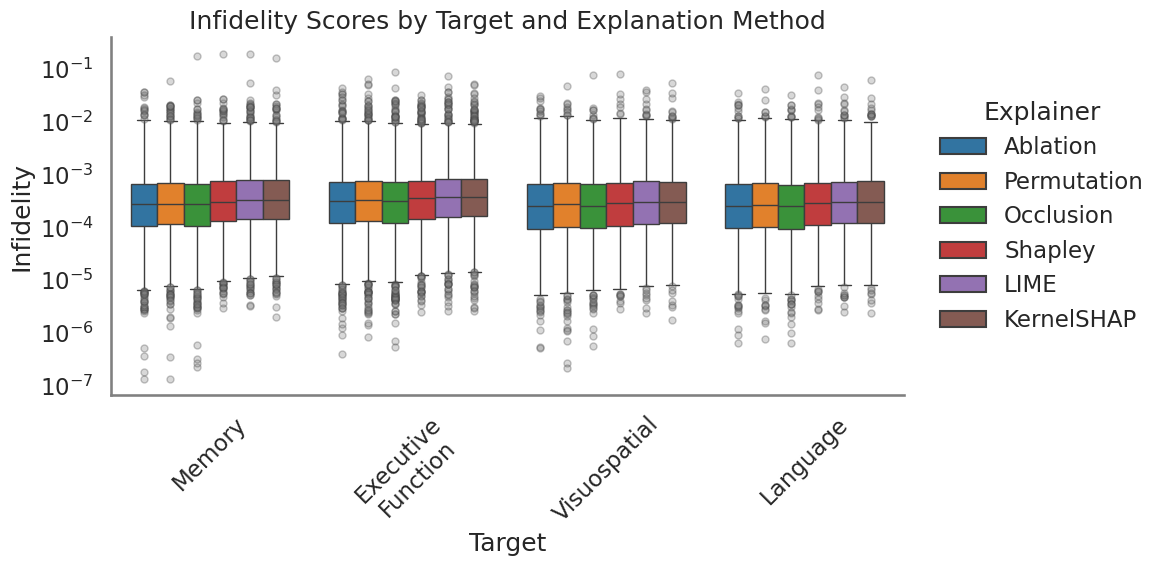

In [39]:
df_infidelity_plot = plot_captum_metric(infidelity_scores, 'Infidelity', title = 'Infidelity Scores by Target and Explanation Method')

## Compute Sensitivity 

In [ ]:
def get_explainer(key, forward_func):
    if key == 'ablation':
        return FeatureAblation(forward_func)
    elif key == 'permutation':
        return FeaturePermutation(forward_func)
    elif key == 'occlusion':
        return Occlusion(forward_func)
    elif key == 'shapley':
        return ShapleyValueSampling(forward_func)
    else:
        raise ValueError(f"Unknown explainer key: {key}")

def compute_metrics(forward_func, X, explainer_keys, perturbation_samples=10, sens_radius=0.02):
    results = {}

    for key in explainer_keys:
        explainer = get_explainer(key, forward_func)

        # Define explanation function
        def explanation_fn(inputs):
            if key in ['ablation', 'occlusion', 'shapley']:
                baseline = torch.zeros_like(inputs)
                return explainer.attribute(inputs, baselines=baseline)
            else:
                return explainer.attribute(inputs)

        # Define perturbation function for infidelity
        def perturb_func(inputs, baselines):
            noise = torch.randn_like(inputs) * 0.01
            return None, inputs + noise

        # Compute infidelity
        inf = infidelity(
            forward_func,
            perturb_func,
            X,
            explanation_fn,
            normalize=True
        )

        # Compute sensitivity
        sens = sensitivity_max(
            explanation_fn,
            X,
            perturb_radius=sens_radius,
            n_perturb_samples=perturbation_samples,
            norm_ord='fro'
        )

        results[key] = {
            'infidelity': inf.item(),
            'sensitivity': sens.item()
        }

    return results

In [ ]:
def compute_sensitivity_max(
    forward_func,        # your model's forward function
    X: torch.Tensor,     # input tensor, shape (N, F)
    attribution_func,    # attribution function that takes input tensor and returns tensor of attributions
    n_perturb_samples: int = 10,
    noise_scale: float = 0.02
) -> torch.Tensor:
    """
    Compute Sensitivity Max for a given attribution method and model.

    Args:
        forward_func: model's forward function
        X: input tensor (N, F)
        attribution_func: function returning attributions for X (should accept a torch.Tensor)
        n_perturb_samples: number of perturbations per sample
        noise_scale: standard deviation of Gaussian noise used for perturbation

    Returns:
        Tensor of sensitivity max values, shape (N,)
    """
    def perturb_func(inputs):
        noise = torch.randn_like(inputs) * noise_scale
        return inputs + noise

    sens_vals = sensitivity_max(
        attribution_func,
        inputs=X,
        perturb_func=perturb_func,
        n_perturb_samples=n_perturb_samples
    )
    return sens_vals


In [42]:
sensitivity_scores = {}

for target, explainer, explainer_f, forward_f in zip(df_y.columns, all_explainers, all_explain_functions, all_funcs): 
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    
    methods = df_attr['method'].unique()

    sensitivity_scores[target] = {}
    
    for method in methods:
        sens_max = compute_sensitivity_max(
        forward_func=forward_f,
        X=X_sampled,
        attribution_func= explainer_f[method],
        n_perturb_samples=10
        )
        # Store the computed scores
        sensitivity_scores[target][method] = sens_max.squeeze().tolist()

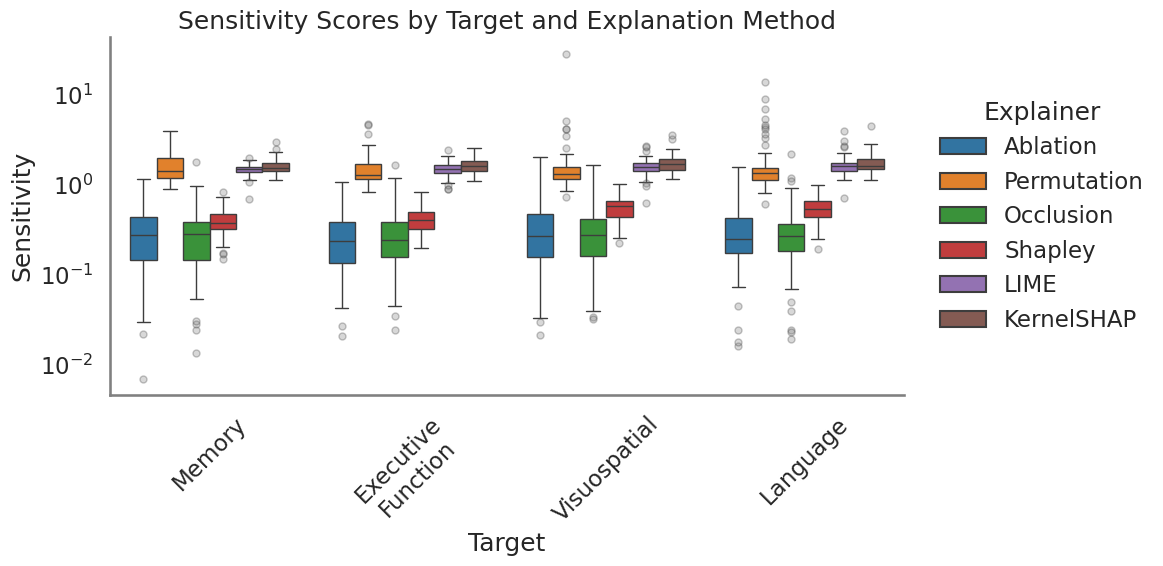

In [44]:
df_sensitivity_plot = plot_captum_metric(sensitivity_scores, 'Sensitivity', title = 'Sensitivity Scores by Target and Explanation Method')

## Summarize and Save Evaluation Metrics

In [ ]:
# Bundle everything into one dictionary
save_dict = {
    "infidelity_scores": infidelity_scores,
    "sensitivity_scores": sensitivity_scores,
    "all_explainers": all_explainers,
}

# Save to a file
with open("../pickle/captum_explainer_outputs.pickle", "wb") as f:
    pickle.dump(save_dict, f)